In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fact_df = pd.read_csv('data/fact_table.csv', encoding='ISO-8859-1')
customer_df = pd.read_csv('data/customer_dim.csv', encoding='ISO-8859-1')
item_df = pd.read_csv('data/item_dim.csv', encoding='ISO-8859-1')
store_df = pd.read_csv('data/store_dim.csv', encoding='ISO-8859-1')
time_df = pd.read_csv('data/time_dim.csv', encoding='ISO-8859-1')

In [3]:
df = (
    fact_df.merge(time_df, how='left', on='time_key')
    .merge(item_df, how='left', on='item_key')
    .merge(customer_df, how='left', on='coustomer_key')
    .merge(store_df, how='left', on='store_key')
)

In [4]:
def group_descs(desc):
    if 'beverage' in desc.lower():
        return 'Beverage'
    elif 'food' in desc.lower():
        return 'Food'
    elif 'coffee' in desc.lower():
        return 'Coffee'
    elif 'dishware' in desc.lower():
        return 'Dishware'
    elif 'gum' in desc.lower():
        return 'Gum'
    else:
        return desc

df['item_type'] = df['desc'].apply(group_descs)

In [5]:
monthly_revenue = df.groupby(['year', 'month', 'item_type'])['total_price'].sum().reset_index()

In [16]:
monthly_revenue

,year,month,item_type,total_price
0,2014,1,Beverage,175429.75
1,2014,1,Coffee,77956.00
2,2014,1,Dishware,39354.00
3,2014,1,Food,149945.00
4,2014,1,Gum,10822.00
...,...,...,...,...
590,2021,1,Dishware,73542.00
591,2021,1,Food,270295.50
592,2021,1,Gum,20714.00
593,2021,1,Kitchen Supplies,70819.50


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [28]:
item_encoder = OneHotEncoder()
encoded_item_types = item_encoder.fit_transform(monthly_revenue[['item_type']]).toarray()
encoded_item_types_df = pd.DataFrame(encoded_item_types, columns=item_encoder.get_feature_names_out(['item_type']))

month_encoder = OneHotEncoder()
encoded_months = month_encoder.fit_transform(monthly_revenue[['month']]).toarray()
encoded_months_df = pd.DataFrame(encoded_months, columns=month_encoder.get_feature_names_out(['month']))

features = pd.concat([encoded_months_df, encoded_item_types_df], axis=1)
target = monthly_revenue['total_price']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=56)

In [29]:
model = RandomForestRegressor(n_estimators=100, random_state=46)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 613076960.648993
R-squared: 0.976768477401435


In [31]:
def predict_revenue(new_month, new_item_type):
    encoded_new_month = month_encoder.transform([[new_month]]).toarray()
    encoded_new_item_type = item_encoder.transform([[new_item_type]]).toarray()
    encoded_new_features = np.hstack([encoded_new_month, encoded_new_item_type])
    new_features_df = pd.DataFrame(encoded_new_features, columns=list(encoded_months_df.columns) + list(encoded_item_types_df.columns))
    return model.predict(new_features_df)[0]

c:\Users\Jeffrey\anaconda3\envs\dsc80\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\Jeffrey\anaconda3\envs\dsc80\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\Jeffrey\anaconda3\envs\dsc80\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\Jeffrey\anaconda3\envs\dsc80\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\Jeffrey\anaconda3\envs\dsc80\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\Jeffrey\anaconda3\envs\dsc80\li

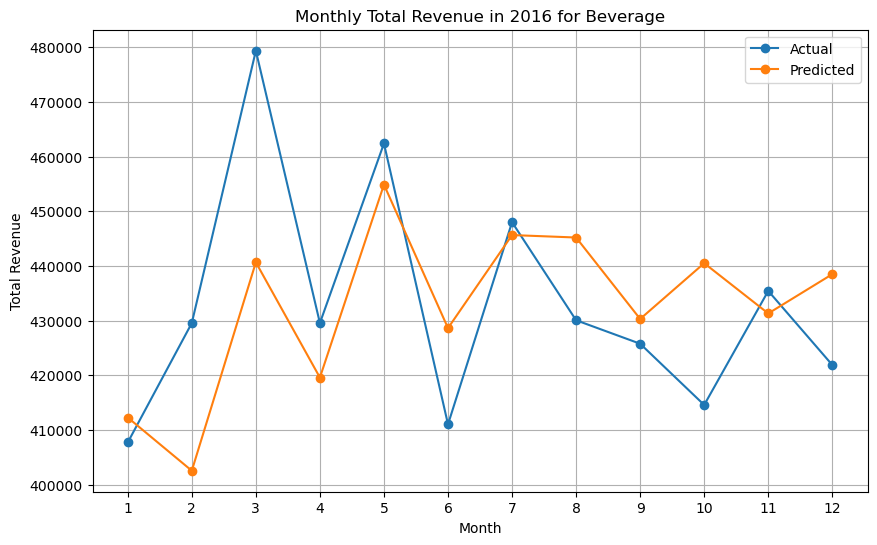

In [41]:
year = 2016
item_type = 'Beverage'
item_monthly_revenue = monthly_revenue[(monthly_revenue['item_type'] == item_type) & (monthly_revenue['year'] == year)]
revenue_predictions = pd.DataFrame({
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
})
fig, ax = plt.subplots(figsize=(10, 6))
revenue_predictions['total_price'] = revenue_predictions['month'].apply(lambda x: predict_revenue(x, item_type))
item_monthly_revenue.set_index('month')['total_price'].plot(kind='line', marker='o', ax=ax, label='Actual')
revenue_predictions.set_index('month')['total_price'].plot(kind='line', marker='o', ax=ax, label='Predicted')
plt.title(f'Monthly Total Revenue in {year} for {item_type}')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.show()